# Step 1: Cleaning
This dataset is the BRIGHTEN (V1 and V2) dataset. It is open-access from Synapse.org.

In [2]:
############ LOAD in custom packages ################
import sys
import re
import os
import pandas as pd
import importlib
import time
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path for script usage
sys.path.append(project_root)

# Import and reload (optional) custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import variables

importlib.reload(pre)
importlib.reload(vis)
importlib.reload(variables)


################ DEFINE column variables from data ###################
from scripts.variables import id_columns
from scripts.variables import all_cols, all_daily_cols, weekly_cols, baseline_cols, drop_weekly_cols
from scripts.variables import daily_cols_v1, daily_v2_sensor_hr, daily_v2_weather, daily_cols_v2 
from scripts.variables import gad_cols, phq9_base, alc_cols, phq9_cols, sleep_cols, gic_cols, sds_cols, phq2_cols

# Define label variables
df_names = ['v1_day', 'v2_day', 'v1_week', 'v2_week']
aggregate_dfs = ['alldays_df','week_df']
df_list = df_names + aggregate_dfs
df_names_with_mis = ['v1_day', 'v2_day', 'v1_week', 'v2_week', 'v1_day_mis','v2_day_mis','v1_week_mis','v2_week_mis']
time_cols = ['month', 'day_of_week']
# Update endings list if order changes
df_endings = ['hr', 'dem', 'nonO','setNaN', 'transformed', 'unskewed','scaled','dropped','int','imp','clean','binned','lag']
df_order_agg = ['raw_merged_df','merge_df','days_df', 'alldays_df']

target_vars = phq2_cols + phq9_cols



### Load in raw files

In [3]:

############ LOAD in raw files  #############
raw_dfs = {}
raw_dfs['phq9'] = pd.read_csv(os.path.join(brighten_dir,'PHQ-9 - Depression.csv'))
raw_dfs['phq2'] = pd.read_csv(os.path.join(brighten_dir,'PHQ-2 - Depression.csv'))
raw_dfs['alc'] = pd.read_csv(os.path.join(brighten_dir,'Alcohol.csv'))
raw_dfs['gad'] = pd.read_csv(os.path.join(brighten_dir,'GAD - Anxiety.csv'))
raw_dfs['sds'] = pd.read_csv(os.path.join(brighten_dir,'SDS - Functional Impairment.csv'))
raw_dfs['sleep'] = pd.read_csv(os.path.join(brighten_dir,'Sleep Quality.csv'))
raw_dfs['gic'] = pd.read_csv(os.path.join(brighten_dir,'Patients Global Impression of Change Scale.csv'))
raw_dfs['mhs'] = pd.read_csv(os.path.join(brighten_dir,'Mental Health Services.csv'))
raw_dfs['phone_v1'] = pd.read_csv(os.path.join(brighten_dir,'Passive Phone Features Brighten V1.csv'))
raw_dfs['phone_v2'] = pd.read_csv(os.path.join(brighten_dir,'Passive Phone Communication Features Brighten V2.csv'))
raw_dfs['weather_v2'] = pd.read_csv(os.path.join(brighten_dir,'Passive Weather Features Brighten V2.csv'))
raw_dfs['mobility_v2'] = pd.read_csv(os.path.join(brighten_dir,'Passive Mobility Features Brighten V2.csv'))
raw_dfs['cluster_v2'] = pd.read_csv(os.path.join(brighten_dir,'Passive Cluster Entries Brighten V2.csv'))
raw_dfs['phq9_baseline'] = pd.read_csv(os.path.join(brighten_dir,'PHQ-9 - Baseline.csv'))
raw_dfs['demo'] = pd.read_csv(os.path.join(brighten_dir,'Baseline Demographics.csv')) # This is Baseline Demographics from SYNAPSE 
raw_dfs['mania'] = pd.read_csv(os.path.join(brighten_dir,'IMPACT Mania and Psychosis Screening.csv'))


### Clean and update column names
Also creating some binary columns by categorizing numeric data

In [4]:
######### CLEANING AND UPDATING DATA ! #####################

index_variables = ['participant_id', 'dt', 'week','day', 'v']
drop_cols = ['ROW_ID','ROW_VERSION']
# Update column names
for name, df in raw_dfs.items():
	df = df.drop([col for col in drop_cols if col in df.columns.to_list()], axis=1)
	if 'phq9Date' in df.columns:
		df['dt'] = (pd.to_datetime(df['phq9Date'])).dt.tz_localize(None)
		df = df.drop(['phq9Date'], axis=1)
	if 'phq2' in name:
		if 'dt_yesterday' in df.columns:
			df['dt'] = (pd.to_datetime(df['dt_yesterday'])).dt.tz_localize(None)
			df = df.drop(['dt_yesterday'], axis=1)
	if 'dt_passive' in df.columns:
		df['dt'] = (pd.to_datetime(df['dt_passive'])).dt.tz_localize(None)
		df = df.drop(['dt_passive'], axis=1)
	if 'dt_response' in df.columns:
		df['dt'] = (pd.to_datetime(df['dt_response'])).dt.tz_localize(None)
		df = df.drop(['dt_response'], axis=1)
	if 'time_in' in df.columns:
		df['dt'] = (pd.to_datetime(df['time_in'])).dt.tz_localize(None)
		df = df.drop(['time_in','time_out'], axis=1)
	if 'baselinePHQ9date' in df.columns:
		df['dt'] = (pd.to_datetime(df['baselinePHQ9date'])).dt.tz_localize(None)
		df = df.drop(['baselinePHQ9date'], axis=1)
	if 'startdate' in df.columns:
		df['dt'] = pd.to_datetime(df['startdate'], errors='coerce').dt.tz_localize(None)
	if 'sum_phq9' in df.columns:
		df.rename(columns={'sum_phq9': 'phq9_sum'}, inplace=True)

	"""Add version to each dataframe
	There were two parts to this study at different times with different data, 
	one where participant IDs start with "ENO", V2, and another where they start with colors (BLUE, YELLOW etc), V1"""
	df['v'] = np.where(df['participant_id'].str.contains('EN0'), 'V2','V1')

	"""If demographic survey or baseline survey from onboarding week, add week = 0 & day = 0"""
	if name in ['alc', 'gad', 'mania', 'demo']:
		df['week'] = 0
		df['day'] = 0



	# Update the dfs dictionary with the modified DataFrame
	raw_dfs[name] = df

	print(name)
	display(df[[var for var in index_variables if var in df.columns]].head())


phq9


,participant_id,dt,week,v
0,BLUE-00048,2014-08-08,1,V1
1,BLUE-00050,2014-08-23,2,V1
2,BLUE-00050,2014-08-30,3,V1
3,BLUE-00050,2014-09-08,4,V1
4,BLUE-00050,2014-09-22,6,V1


phq2


,participant_id,dt,week,day,v
0,BLUE-00048,2014-08-01 19:27:42,3,0,V1
1,BLUE-00048,2014-08-02 15:13:09,4,1,V1
2,BLUE-00048,2014-08-04 03:58:23,4,2,V1
3,BLUE-00048,2014-08-04 16:53:04,4,3,V1
4,BLUE-00048,2014-08-07 14:25:30,4,6,V1


alc


,participant_id,dt,week,day,v
0,BLUE-00048,2014-08-01 10:56:43,0,0,V1
1,BLUE-00049,2014-08-01 16:28:01,0,0,V1
2,BLUE-00050,2014-08-09 02:22:18,0,0,V1
3,BLUE-00051,2014-08-05 17:32:17,0,0,V1
4,BLUE-00052,2014-08-04 21:23:52,0,0,V1


gad


,participant_id,dt,week,day,v
0,BLUE-00048,2014-08-01 10:59:30,0,0,V1
1,BLUE-00049,2014-08-01 16:31:13,0,0,V1
2,BLUE-00050,2014-08-09 02:30:10,0,0,V1
3,BLUE-00051,2014-08-05 17:34:20,0,0,V1
4,BLUE-00052,2014-08-04 21:27:28,0,0,V1


sds


,participant_id,dt,week,v
0,BLUE-00048,2014-08-01 11:02:04,3.0,V1
1,BLUE-00048,2014-08-08 15:14:35,4.0,V1
2,BLUE-00049,2014-08-01 16:34:51,1.0,V1
3,BLUE-00050,2014-08-09 02:35:19,1.0,V1
4,BLUE-00050,2014-08-24 04:39:47,4.0,V1


sleep


,participant_id,dt,week,v
0,BLUE-00048,2014-08-01 11:03:19,3,V1
1,BLUE-00049,2014-08-01 16:33:20,1,V1
2,BLUE-00050,2014-08-09 02:36:07,1,V1
3,BLUE-00050,2014-09-06 16:31:54,5,V1
4,BLUE-00050,2014-11-02 17:14:45,14,V1


gic


,participant_id,dt,week,v
0,BLUE-00048,2014-08-08 15:15:07,4,V1
1,BLUE-00050,2014-08-24 04:40:29,4,V1
2,BLUE-00050,2014-08-31 00:01:00,5,V1
3,BLUE-00051,2014-08-11 19:33:47,2,V1
4,BLUE-00051,2014-08-18 13:34:21,3,V1


mhs


,participant_id,dt,week,v
0,BLUE-00048,2014-08-01 11:00:48,3,V1
1,BLUE-00049,2014-08-01 16:32:31,1,V1
2,BLUE-00050,2014-08-09 02:32:57,1,V1
3,BLUE-00050,2014-09-09 01:23:09,6,V1
4,BLUE-00050,2014-11-03 16:37:43,14,V1


phone_v1


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_24146/1557771924.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['dt'] = (pd.to_datetime(df['dt_passive'])).dt.tz_localize(None)


,participant_id,dt,week,day,v
0,BLUE-00048,2014-08-05,1.0,5.0,V1
1,BLUE-00048,2014-08-03,1.0,3.0,V1
2,BLUE-00048,2014-08-12,2.0,12.0,V1
3,BLUE-00048,2014-08-02,1.0,2.0,V1
4,BLUE-00048,2014-08-06,1.0,6.0,V1


phone_v2


,participant_id,dt,week,v
0,EN00066,2016-08-24,1,V2
1,EN00066,2016-08-25,1,V2
2,EN00066,2016-08-26,1,V2
3,EN00066,2016-08-27,1,V2
4,EN00066,2016-08-28,1,V2


weather_v2


,participant_id,dt,v
0,EN00033,2016-08-13,V2
1,EN00033,2016-08-14,V2
2,EN00033,2016-08-15,V2
3,EN00033,2016-08-16,V2
4,EN00033,2016-08-17,V2


mobility_v2


,participant_id,dt,week,v
0,EN00538,2016-11-14,0,V2
1,EN00538,2016-11-15,0,V2
2,EN00538,2016-11-16,0,V2
3,EN00538,2016-11-17,0,V2
4,EN00538,2016-11-18,0,V2


cluster_v2


,participant_id,dt,week,v
0,EN00033,2016-08-13 08:23:00,0,V2
1,EN00033,2016-08-13 15:51:00,0,V2
2,EN00033,2016-08-13 23:36:00,0,V2
3,EN00033,2016-08-14 00:00:00,0,V2
4,EN00033,2016-08-14 19:43:00,0,V2


phq9_baseline


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_24146/1557771924.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['dt'] = (pd.to_datetime(df['baselinePHQ9date'])).dt.tz_localize(None)


,participant_id,dt,v
0,BLUE-00048,2014-07-11,V1
1,BLUE-00049,2014-07-31,V1
2,BLUE-00050,2014-08-02,V1
3,BLUE-00051,2014-08-02,V1
4,BLUE-00052,2014-08-04,V1


demo


,participant_id,dt,week,day,v
0,BLUE-00048,2014-07-11 10:45:00,0,0,V1
1,BLUE-00049,2014-07-31 21:21:00,0,0,V1
2,BLUE-00050,2014-08-02 10:46:00,0,0,V1
3,BLUE-00051,2014-08-02 17:50:00,0,0,V1
4,BLUE-00052,2014-08-04 09:07:00,0,0,V1


mania


,participant_id,dt,week,day,v
0,BLUE-00048,2014-08-01 06:58:14,0,0,V1
1,BLUE-00049,2014-08-01 12:29:06,0,0,V1
2,BLUE-00050,2014-08-08 19:27:25,0,0,V1
3,BLUE-00051,2014-08-05 13:33:22,0,0,V1
4,BLUE-00052,2014-08-04 14:25:54,0,0,V1


In [5]:
#### create binary and category variables
raw_dfs['alc']['alc_cat'] = raw_dfs['alc']['alc_sum'].apply(pre.cat_alc)
raw_dfs['gad']['gad_cat'] = raw_dfs['gad']['gad7_sum'].apply(pre.cat_gad)
raw_dfs['phq9']['phq9_cat'] = raw_dfs['phq9']['phq9_sum'].apply(pre.cat_phq9)
raw_dfs['phq9']['phq9_bin'] = raw_dfs['phq9']['phq9_sum'].apply(pre.bin_phq9)
raw_dfs['phq2']['phq2_bin'] = raw_dfs['phq2']['phq2_sum'].apply(pre.bin_phq2)



In [ ]:
# Investigate if there are any rows where there are multiple entries on the same day (dt)-- or if days can be combined into one row without data loss
for name, df in raw_dfs.items():
	print(name)
	df_clean=df.drop_duplicates()
	if 'dt' in df_clean.columns:
		for i, (key, sub_day_df) in enumerate(df_clean.groupby(['participant_id', 'dt'])):
			if sub_day_df.shape[0] > 1:
				sub_day_df = sub_day_df.dropna(axis=1)
				display(sub_day_df)


phq9


,participant_id,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,v,phq9_cat,phq9_bin
4302,EN00077,3,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-09-16,V2,0,0
4439,EN00077,3,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2016-09-16,V2,0,0


,participant_id,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,v,phq9_cat,phq9_bin
4294,EN00077,4,2,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2016-09-23,V2,0,0
4664,EN00077,4,3,0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2016-09-23,V2,0,0


,participant_id,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,v,phq9_cat,phq9_bin
3727,EN00080,2,10,2,2.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,2016-09-09,V2,2,1
4152,EN00080,2,15,1,3.0,2.0,3.0,1.0,3.0,1.0,1.0,0.0,2016-09-09,V2,3,1


,participant_id,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,v,phq9_cat,phq9_bin
3677,EN00080,3,4,0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,2016-09-16,V2,0,0
4452,EN00080,3,7,0,2.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,2016-09-16,V2,1,0


,participant_id,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,v,phq9_cat,phq9_bin
3777,EN00080,4,3,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2016-09-23,V2,0,0
3863,EN00080,4,3,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2016-09-23,V2,0,0


,participant_id,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,v,phq9_cat,phq9_bin
3710,EN00082,2,24,3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,2016-09-09,V2,4,1
4765,EN00082,2,21,3,3.0,3.0,3.0,3.0,1.0,3.0,2.0,0.0,2016-09-09,V2,4,1


,participant_id,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,v,phq9_cat,phq9_bin
3826,EN00082,3,23,3,3.0,2.0,3.0,3.0,3.0,3.0,3.0,0.0,2016-09-16,V2,4,1
4040,EN00082,3,23,3,3.0,3.0,3.0,2.0,3.0,3.0,3.0,0.0,2016-09-16,V2,4,1


,participant_id,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,v,phq9_cat,phq9_bin
4318,EN00082,4,15,2,1.0,3.0,3.0,2.0,1.0,2.0,1.0,0.0,2016-09-23,V2,3,1
4694,EN00082,4,15,3,1.0,1.0,2.0,2.0,2.0,2.0,2.0,0.0,2016-09-23,V2,3,1


,participant_id,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,v,phq9_cat,phq9_bin
4427,EN00083,2,10,1,1.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,2016-09-09,V2,2,1
4523,EN00083,2,11,1,1.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,2016-09-09,V2,2,1


,participant_id,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,v,phq9_cat,phq9_bin
3714,EN00083,3,13,1,1.0,3.0,3.0,3.0,0.0,2.0,0.0,0.0,2016-09-16,V2,2,1
4825,EN00083,3,9,1,1.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,2016-09-16,V2,1,0


,participant_id,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,v,phq9_cat,phq9_bin
3796,EN00083,4,11,1,1.0,3.0,2.0,3.0,1.0,0.0,0.0,0.0,2016-09-23,V2,2,1
4634,EN00083,4,7,1,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,2016-09-23,V2,1,0


,participant_id,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,v,phq9_cat,phq9_bin
3813,EN00084,4,21,2,1.0,3.0,3.0,3.0,2.0,3.0,3.0,1.0,2016-09-23,V2,4,1
4052,EN00084,4,11,1,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2016-09-23,V2,2,1


phq2
alc
gad
sds
sleep
gic
mhs
phone_v1
phone_v2
weather_v2
mobility_v2
cluster_v2
phq9_baseline
demo
mania


I know there are non-numeric and categorical data in the Demographics table.

We have to encode and one-hot encode these data

In [7]:
display(raw_dfs['cluster_v2'])

,participant_id,week,cid,category,subcategories,dt,v
0,EN00033,0,home,home,home,2016-08-13 08:23:00,V2
1,EN00033,0,xNot,none,none,2016-08-13 15:51:00,V2
2,EN00033,0,home,home,home,2016-08-13 23:36:00,V2
3,EN00033,0,home,home,home,2016-08-14 00:00:00,V2
4,EN00033,0,xNot,none,none,2016-08-14 19:43:00,V2
...,...,...,...,...,...,...,...
59661,ES05073,8,home,home,home,2017-03-20 16:12:00,V1
59662,ES05073,8,xNot,none,none,2017-03-21 16:05:00,V1
59663,ES05073,8,home,home,home,2017-03-22 09:51:00,V1
59664,ES05073,8,xNot,none,none,2017-03-22 20:44:00,V1


In [6]:

### Turn categorical variables to numerical variables

# Demographics DF 

# Including turning participant ID into
# Convert to category type
# Apply LabelEncoder to each categorical column
label_encoders = {}  # Store encoders for later use
demo_clean = {}

for col in raw_dfs['demo'].columns:
    if 'dt' not in col and 'startdate' not in col and col!='v':
        demo_clean[f"{col}"] = []
        le = LabelEncoder()
        col_series = le.fit_transform(raw_dfs['demo'][col])  # Transform to numeric IDs
        demo_clean[col] = col_series
        label_encoders[col] = le  # Save encoder for inverse transform if needed
        #print(col, le.classes_)

# Clean up demo_clean and add back in some of the columns from demo which we want to save non-encoded
demo_clean['dt'] = raw_dfs['demo']['dt'].copy()
display('participant_id',demo_clean['participant_id'])
demo_clean['num_id'] = demo_clean['participant_id']
display('num id', demo_clean['num_id'])

demo_clean['participant_id'] = raw_dfs['demo']['participant_id']
demo_clean['v'] = raw_dfs['demo']['v']
del demo_clean['study']

# Create demo_clean into df
raw_dfs['demo_clean'] = pd.DataFrame(demo_clean)
display(raw_dfs['demo_clean'])

# Save encoder keys as df
encoder_key = {}
for col, le in label_encoders.items():
    if 'participant_id' not in col:
        encoder_key[col] = dict(enumerate(le.classes_))
rows = []
for col, le in label_encoders.items():
    if 'participant_id' not in col:
        for i, label in enumerate(le.classes_):
            rows.append({"column": col, "encoding": i, "label": label})

encoder_df = pd.DataFrame(rows)
encoder_df.to_csv(os.path.join(brighten_dir, 'demographic_encoder_key.csv'), index=False)

# Save ID keys
key = raw_dfs['demo_clean'][['participant_id','num_id','v']].drop_duplicates()
key.to_csv(os.path.join(brighten_dir, 'id_key.csv'), index=False)


# Save out as separate csv
raw_dfs['demo_clean'].to_csv(os.path.join(brighten_dir, f'demographics_clean.csv'))
print(f'Saved df to demographics_clean.csv')






'participant_id'

array([   0,    1,    2, ..., 2190, 2191, 2192])

'num id'

array([   0,    1,    2, ..., 2190, 2191, 2192])

,participant_id,gender,education,working,income_satisfaction,income_lastyear,marital_status,race,age,heard_about_us,device,study_arm,week,day,dt,num_id,v
0,BLUE-00048,1,2,1,3,6,2,2,14,6,1,2,0,0,2014-07-11 10:45:00,0,V1
1,BLUE-00049,1,2,0,3,6,0,2,30,6,0,2,0,0,2014-07-31 21:21:00,1,V1
2,BLUE-00050,1,3,1,3,6,1,0,38,6,1,2,0,0,2014-08-02 10:46:00,2,V1
3,BLUE-00051,1,4,0,3,6,1,6,56,6,1,2,0,0,2014-08-02 17:50:00,3,V1
4,BLUE-00052,1,4,0,3,6,2,6,34,6,1,2,0,0,2014-08-04 09:07:00,4,V1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2188,YELLOW-00260,1,4,1,1,5,2,6,23,1,0,1,0,0,2014-12-07 10:44:00,2188,V1
2189,YELLOW-00261,0,0,0,1,2,1,6,30,1,0,1,0,0,2014-12-05 18:07:00,2189,V1
2190,YELLOW-00262,0,3,1,1,5,2,0,3,3,0,1,0,0,2014-12-06 20:33:00,2190,V1
2191,YELLOW-00263,0,3,0,1,5,2,3,6,1,0,1,0,0,2014-12-07 01:12:00,2191,V1


Saved df to demographics_clean.csv


### Merge together all the DFs into a large DF on the ID columns


In [10]:
### Create merge df 

# Merging based on consistent columns-- so there shouldn't be any discrepancy 
# even if the week/dt is wrong, it will just create a new row for that dt if necessary
raw_merged_df = pd.DataFrame()

for name, df in raw_dfs.items():
	# skip cluster_v2 because it has timeIn and timeOut and we don't want to lose that 
	# skip demo and demo_clean -- we'll merge in demo_clean later
	if 'cluster_v2' in name or 'demo' in name: 
		continue 
	if 'dt' in df.columns:
		df['dt'] = pd.to_datetime(df['dt']).dt.normalize() # take out time
	print(f'for df: {name}')
	# Check if both 'num_id' and 'dt' exist in the current df
	if raw_merged_df.empty:
		# Drop any columns from demo df (which aren't id) because we are going to add back in the encoded versions
		demo_columns = [col for col in df.columns if col in raw_dfs['demo_clean'].columns and col not in id_columns]
		raw_merged_df = df.drop(columns=demo_columns).copy()
		raw_merged_df = df.copy()  # Start with the first valid DataFrame
		print(f'Merged in {name}')
	else:
		demo_columns_present = [col for col in df.columns if col in raw_dfs['demo_clean'].columns and col not in id_columns]
		df_nonDemo = df.drop(columns=demo_columns).copy()
		consistent_columns = [var for var in df_nonDemo.columns if var in raw_merged_df.columns]
		new_columns = [col for col in df_nonDemo.columns if col not in consistent_columns]
		raw_merged_df = pd.merge(raw_merged_df, df_nonDemo, on=consistent_columns, how='outer')
		print(f'Merged in {name} on {consistent_columns}. \n New columns: {new_columns}')


if any('_x' in col or '_y' in col for col in raw_merged_df.columns):
	pattern = r'_x$|_y$'  # match column names that END in _x or _y
	matches = [col for col in raw_merged_df.columns if re.search(pattern, col)]
	print('Error: duplicated column with _x or _y', matches)
	

# Save merge_df to csv
raw_merged_df['dt'] = pd.to_datetime(raw_merged_df['dt'], errors='coerce')
consistent_columns = [var for var in df_nonDemo.columns if var in raw_merged_df.columns]
raw_merged_df = pd.merge(raw_merged_df, raw_dfs['demo_clean'], on=consistent_columns, how='outer')
# Now sort by id, week and dt, so it should be obvious if any dt's are in the wrong week
raw_merged_df = raw_merged_df.sort_values(by=['participant_id', 'week', 'dt'])
raw_merged_df.to_csv(os.path.join(brighten_dir, 'raw_merged_df.csv'), index=False)
print('Saved raw_merged_df to raw_merged_df.csv')



for df: phq9
Merged in phq9
for df: phq2
Merged in phq2 on ['week', 'dt', 'v']. 
 New columns: ['day', 'phq2_1', 'phq2_2', 'phq2_sum', 'phq2_bin']
for df: alc
Merged in alc on ['week', 'dt', 'v', 'day']. 
 New columns: ['alc_1', 'alc_2', 'alc_3', 'alc_sum', 'alc_cat']
for df: gad
Merged in gad on ['week', 'dt', 'v', 'day']. 
 New columns: ['gad7_1', 'gad7_2', 'gad7_3', 'gad7_4', 'gad7_5', 'gad7_6', 'gad7_7', 'gad7_8', 'gad7_sum', 'gad_cat']
for df: sds
Merged in sds on ['week', 'dt', 'v']. 
 New columns: ['sds_1', 'sds_2', 'sds_3', 'stress', 'support']
for df: sleep
Merged in sleep on ['week', 'dt', 'v']. 
 New columns: ['sleep_1', 'sleep_2', 'sleep_3']
for df: gic
Merged in gic on ['week', 'dt', 'v']. 
 New columns: ['mood_1']
for df: mhs


: 

### Preprocessing the Daily DF 
- Combining rows from the same day, by averaging over the day or using bfill and ffill
- Reindexing the data to include all possible days, since only days with data are currently shown (this will allow us to impute data over missing days, and see how many dayss are missing)

In [ ]:
# test combining day function

def test_combine_day():
	data = {
		'num_id': [1]*4,
		'dt': pd.to_datetime(['2020-01-01 14:37:25', '2020-01-01 02:40:01', '2020-01-08 09:03:46', '2020-01-15 18:44:15']),
		'valueA': [2, 0, 0, 0],
		'valueB': ["0", "2", "2", "4"],
		'week': [1, 1, 2, 3]
	}
	df = pd.DataFrame(data)
	df['dt'] = pd.to_datetime(df['dt']).dt.normalize() # take out time
	days_df = pre.combine_same_day(df)

	expected_valueA = [1, 0, 0] # averaging numerical variables
	expected_valueB = ["2", "2", "4"] # using last value for categorical variables

	assert days_df['valueA'].tolist() == expected_valueA, f"Expected {expected_valueA}, got {days_df['valueA'].tolist()}"
	assert days_df['valueB'].tolist() == expected_valueB, f"Expected {expected_valueB}, got {days_df['valueB'].tolist()}"

test_combine_day()

In [ ]:

def test_reindex():
	data = {
		"num_id": pd.to_numeric([1,1,1,2,2,3,3,3]),
		"dt": pd.to_datetime([
			"2020-01-01", "2020-01-03", "2020-01-06",
			"2020-01-01", "2020-01-02",
			"2020-01-06","2020-01-09","2020-01-09"
		], format='%Y-%m-%d'),
		"valueA": [2, 0, 0, 1, 2, 1, 2, 3],
		"valueB": ["2", "2", "4", "4", None, None, None, None],
	}
	df = pd.DataFrame(data)

	# --- 1. Test combine_same_day ---
	days_df = pre.combine_same_day(df)

	display(days_df)


	# for num_id=3, dt=2020-01-09 has duplicates (2 and 3)
	# so valueA should average to 2.5, valueB keep first ("2" if ordering is stable)
	expected_days = pd.DataFrame({
		"num_id": pd.to_numeric([1,1,1,2,2,3,3]),
		"dt": pd.to_datetime([
			"2020-01-01", "2020-01-03", "2020-01-06",
			"2020-01-01", "2020-01-02",
			"2020-01-06","2020-01-09"
		], format='%Y-%m-%d'),
		"valueA": [2,0,0,1,2,1,2.5],
		"valueB": ["2","2","4","4",None,None,"2"]
	})

	expected_days["dt"] = pd.to_datetime(expected_days["dt"])
	days_df["dt"] = pd.to_datetime(days_df["dt"])    
	
	assert (
	days_df["dt"].tolist() == expected_days["dt"].tolist()
	)
	

	# --- 2. Test reindex_to_all_days ---
	all_days_df = pre.reindex_to_all_days(days_df)

	expected_dt = pd.date_range("2020-01-01", "2020-01-09", freq="D")
	# check that each num_id has continuous daily rows
	for pid in all_days_df["num_id"].unique():
		sub = all_days_df.loc[all_days_df["num_id"]==pid, "dt"]
		assert sub.tolist() == expected_dt[(expected_dt>=sub.min()) & (expected_dt<=sub.max())].tolist(), \
			f"Participant {pid} dates not continuous: {sub}"

	print("✅ test_reindex passed")

test_reindex()

,dt,num_id,valueA,valueB
0,2020-01-01,1.0,2.0,2
1,2020-01-03,1.0,0.0,2
2,2020-01-06,1.0,0.0,4
3,2020-01-01,2.0,1.0,4
4,2020-01-02,2.0,2.0,None
5,2020-01-06,3.0,1.0,None
6,2020-01-09,3.0,2.5,None


✅ test_reindex passed


In [ ]:
start=time.time()

########## Combine rows from the same day ###############
raw_merged_df = pd.read_csv(os.path.join(brighten_dir, 'raw_merged_df.csv'))
days_df = pre.combine_same_day(raw_merged_df)
days_df.to_csv(os.path.join(brighten_dir, 'days_df.csv'), index=False)
print(f'Saved final filled dataframe to days_df.csv, shape: {days_df.shape}')


############ Reindex to alldays_df & add indicators ##########
## days_df -> _alldays, reindexing each range of dates for a participant to include all dates in that range
alldays_df = pre.reindex_to_all_days(days_df)

## Add idx, which allows multilevel grouping by participant-day ########
alldays_df['idx'] = alldays_df['num_id'].astype(str) +'_'+ alldays_df['day'].astype(str)
if not 'idx' in id_columns:
	id_columns.append('idx')
	print(id_columns)


## Add weekday
alldays_df['day_of_week'] = alldays_df['dt'].dt.weekday + 1
alldays_df['month'] = alldays_df['dt'].dt.month
## Add season
seasons = {
    'fall': [9, 10, 11],
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8]
}

# Assign season labels (strings)
for season, months in seasons.items():
    alldays_df.loc[alldays_df['month'].isin(months), 'season'] = season

# Encode seasons numerically
season_mapping = {season: i + 1 for i, season in enumerate(seasons.keys())}
alldays_df['season_num'] = alldays_df['season'].map(season_mapping)

## Save alldays_df
alldays_df.to_csv(os.path.join(brighten_dir, 'alldays_df.csv'), index=False)
print(f'Saved alldays_df.csv to brighten_dir, shape: {alldays_df.shape}')

## Save encoder mapping
season_encoder_df = pd.DataFrame(
    list(season_mapping.items()), columns=['season', 'season_num']
)
season_encoder_df.to_csv(os.path.join(brighten_dir, 'season_encoder_key.csv'), index=False)
print("Saved season_encoder_key.csv")

end = time.time()
print(f'Cell computation time: {end-start} seconds')


week
week_id


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/181000543.py:1: DtypeWarning: Columns (44,45,103,104,105) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_merged_df = pd.read_csv(os.path.join(brighten_dir, 'alldays_df.csv'))


In [ ]:
# test week assignment

def test_week_assignment():
	data = {
		'num_id': [1,1,1,1,2,2,2,2,3],
		'dt': pd.to_datetime(['2020-01-01', '2020-01-03', '2020-01-08', '2020-01-15','2020-01-01', '2020-01-09', '2020-01-08', '2020-01-15','2019-08-15']),
		'week': [0,0,0,0,0,0,0,0,0]
	}
	df = pd.DataFrame(data)
	
	correctWeeks = []
	for i, (key, sub_df) in enumerate(df.groupby(['num_id'])):
		sub_df['dt'] = pd.to_datetime(sub_df['dt'], format='mixed')
		sub_df = sub_df.sort_values('dt').reset_index(drop=True)
		first_date = sub_df.loc[0, 'dt']
		sub_df['week'] = sub_df['week'] + ((sub_df['dt'] - first_date).dt.days // 7)
		correctWeeks.append(sub_df)

	merge_df_correctWeeks = pd.concat(correctWeeks).reset_index(drop=True)
	expected_weeks = [0, 0, 1, 2, 0, 1, 1, 2, 0]

	display(merge_df_correctWeeks)

	assert merge_df_correctWeeks['week'].tolist() == expected_weeks, f"Expected {expected_weeks}, got {merge_df_correctWeeks['week'].tolist()}"

test_week_assignment()



,num_id,dt,week
0,1,2020-01-01,0
1,1,2020-01-03,0
2,1,2020-01-08,1
3,1,2020-01-15,2
4,2,2020-01-01,0
5,2,2020-01-08,1
6,2,2020-01-09,1
7,2,2020-01-15,2
8,3,2019-08-15,0


In [177]:
alldays_df

,dt,participant_id,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,...,race,age,heard_about_us,device,study_arm,num_id,idx,day_of_week,month,season
0,2014-07-11,BLUE-00048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,14.0,6.0,1.0,2.0,0.0,0.0_0,5,7,summer
1,2014-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0_1,6,7,summer
2,2014-07-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0_2,7,7,summer
3,2014-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0_3,1,7,summer
4,2014-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0_4,2,7,summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78644,2015-01-15,YELLOW-00263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2191.0,2191.0_39,4,1,winter
78645,2015-01-16,YELLOW-00263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2191.0,2191.0_40,5,1,winter
78646,2015-01-17,YELLOW-00263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2191.0,2191.0_41,6,1,winter
78647,2015-01-18,YELLOW-00263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2191.0,2191.0_42,7,1,winter


In [ ]:
######### Reassign week numbers based on all the available data for each participant ##############
raw_merged_df = pd.read_csv(os.path.join(brighten_dir, 'alldays_df.csv'))

correctWeeks = []
for key, sub_df in raw_merged_df.groupby('num_id'):
	sub_df['dt'] = pd.to_datetime(sub_df['dt'], format='mixed')
	sub_df = sub_df.sort_values('dt').reset_index(drop=True)
	first_date = sub_df.loc[0, 'dt']
	sub_df['week'] = 0
	sub_df['week'] = sub_df['week'] + ((sub_df['dt'] - first_date).dt.days // 7)
	correctWeeks.append(sub_df)


merge_df_correctWeeks = pd.concat(correctWeeks).reset_index(drop=True)
merge_df_correctWeeks['week_id'] = merge_df_correctWeeks['num_id'].astype(str) + '_' + merge_df_correctWeeks['week'].astype(str)
display(merge_df_correctWeeks[id_columns+[col for col in merge_df_correctWeeks if col not in ['num_id','dt','week']]])
merge_df_correctWeeks.to_csv(os.path.join(brighten_dir, 'merge_df_correctWeeks.csv'))


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/2386160958.py:2: DtypeWarning: Columns (44,45,103,104,105) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_merged_df = pd.read_csv(os.path.join(brighten_dir, 'alldays_df.csv'))


,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,race,age,heard_about_us,device,study_arm,idx,day_of_week,month,season,week_id
0,0.0,2014-07-11,0,0,0.0_0,0.0_0,V1,summer,5,NaN,...,2.0,14.0,6.0,1.0,2.0,0.0_0,5,7,summer,0.0_0
1,0.0,2014-07-12,0,1,0.0_0,0.0_1,NaN,summer,6,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0_1,6,7,summer,0.0_0
2,0.0,2014-07-13,0,2,0.0_0,0.0_2,NaN,summer,7,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0_2,7,7,summer,0.0_0
3,0.0,2014-07-14,0,3,0.0_0,0.0_3,NaN,summer,1,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0_3,1,7,summer,0.0_0
4,0.0,2014-07-15,0,4,0.0_0,0.0_4,NaN,summer,2,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0_4,2,7,summer,0.0_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78644,2191.0,2015-01-15,5,39,2191.0_5,2191.0_39,V1,winter,4,Health tips,...,NaN,NaN,NaN,NaN,NaN,2191.0_39,4,1,winter,2191.0_5
78645,2191.0,2015-01-16,5,40,2191.0_5,2191.0_40,V1,winter,5,Health tips,...,NaN,NaN,NaN,NaN,NaN,2191.0_40,5,1,winter,2191.0_5
78646,2191.0,2015-01-17,5,41,2191.0_5,2191.0_41,V1,winter,6,Health tips,...,NaN,NaN,NaN,NaN,NaN,2191.0_41,6,1,winter,2191.0_5
78647,2191.0,2015-01-18,6,42,2191.0_6,2191.0_42,V1,winter,7,Health tips,...,NaN,NaN,NaN,NaN,NaN,2191.0_42,7,1,winter,2191.0_6


In [ ]:
# Also check if the 'week' variable in the dfs is actually accurate
start = time.time()

raw_merged_df = pd.read_csv(os.path.join(brighten_dir, 'merge_df_correctWeeks.csv'))
incorrect_weeks = []
for i, (key, sub_week_df) in enumerate(raw_merged_df.groupby(['participant_id', 'week'])):
	if not 'dt' in sub_week_df.columns:
		continue
	else:
		sub_week_df = sub_week_df.copy()
		sub_week_df['dt'] = pd.to_datetime(sub_week_df['dt'], format='ISO8601')
		sub_week_df = sub_week_df.sort_values('dt')
		days = df['dt'].replace('', pd.NA).dropna()
		first_day_in_week, last_day_in_week = days.iloc[0], days.iloc[-1]
		if (last_day_in_week-first_day_in_week).days > 7:
			incorrect_weeks.append(key) #add sub df and week number tuple to the df-specific incorrect_weeks list

print(f'For {name}, {len(set(incorrect_weeks))} subject-week dfs with incorrect weeks')
			
end = time.time()
print(f'Cell computation time: {end-start}')                


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/1993942882.py:4: DtypeWarning: Columns (45,46,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_merged_df = pd.read_csv(os.path.join(brighten_dir, 'merge_df_correctWeeks.csv'))


For demo_clean, 12201 subject-week dfs with incorrect weeks
Cell computation time: 3.018476963043213


In [ ]:
###########  Save as V1 and V2 ##############
alldays_df = pd.read_csv(os.path.join(brighten_dir, 'merge_df_correctWeeks.csv'))

v1 = alldays_df[alldays_df['v']=='V1']
v1 = v1.drop(columns=daily_cols_v2)
v1.to_csv(os.path.join(brighten_dir, 'v1_day.csv'), index=False)
display(v1)
# print(v1.columns.to_list())

v2_non_hr = alldays_df[alldays_df['v']=='V2']
v2_non_hr = v2_non_hr.drop(columns=daily_cols_v1)
v2_non_hr.to_csv(os.path.join(brighten_dir, 'v2_non_hr.csv'), index=False)
display(v2_non_hr)
# print(v2_non_hr.columns.to_list())


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/321150886.py:2: DtypeWarning: Columns (45,46,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  alldays_df = pd.read_csv(os.path.join(brighten_dir, 'merge_df_correctWeeks.csv'))


,Unnamed: 0,dt,participant_id,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,...,heard_about_us,device,study_arm,num_id,idx,day_of_week,month,season,week,week_id
0,0,2014-07-11,BLUE-00048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,1.0,2.0,0.0,0.0_0,5,7,summer,0,0.0_0
21,21,2014-08-01,BLUE-00048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0_21,5,8,summer,3,0.0_3
22,22,2014-08-02,BLUE-00048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0_22,6,8,summer,3,0.0_3
23,23,2014-08-03,BLUE-00048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0_23,7,8,summer,3,0.0_3
24,24,2014-08-04,BLUE-00048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0_24,1,8,summer,3,0.0_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78644,78644,2015-01-15,YELLOW-00263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2191.0,2191.0_39,4,1,winter,5,2191.0_5
78645,78645,2015-01-16,YELLOW-00263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2191.0,2191.0_40,5,1,winter,5,2191.0_5
78646,78646,2015-01-17,YELLOW-00263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2191.0,2191.0_41,6,1,winter,5,2191.0_5
78647,78647,2015-01-18,YELLOW-00263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2191.0,2191.0_42,7,1,winter,6,2191.0_6


['Unnamed: 0', 'dt', 'participant_id', 'phq9_sum', 'phq9_1', 'phq9_2', 'phq9_3', 'phq9_4', 'phq9_5', 'phq9_6', 'phq9_7', 'phq9_8', 'phq9_9', 'v', 'day', 'phq2_1', 'phq2_2', 'phq2_sum', 'alc_1', 'alc_2', 'alc_3', 'alc_sum', 'gad7_1', 'gad7_2', 'gad7_3', 'gad7_4', 'gad7_5', 'gad7_6', 'gad7_7', 'gad7_8', 'gad7_sum', 'sds_1', 'sds_2', 'sds_3', 'stress', 'support', 'sleep_1', 'sleep_2', 'sleep_3', 'mood_1', 'mhs_1', 'mhs_2', 'mhs_3', 'mhs_4', 'mhs_5', 'cohort', 'user_phone_type', 'aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'mobility', 'mobility_radius', 'sms_count', 'sms_length', 'unreturned_calls', 'hours_accounted_for', 'hours_stationary', 'hours_stationary_nhw', 'hours_walking', 'cid', 'category', 'subcategories', 'phq9_1_base', 'phq9_2_base', 'phq9_3_base', 'phq9_4_base', 'phq9_5_base', 'phq9_6_base', 'phq9_7_base', 'phq9_8_base', 'phq9_9_base', 'study', 'screen_1', 'screen_2', 'screen_3', 'screen_4', 'gender', 'education', '

,Unnamed: 0,dt,participant_id,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,...,heard_about_us,device,study_arm,num_id,idx,day_of_week,month,season,week,week_id
10226,10226,2016-08-12,EN00033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.0,2.0,213.0,213.0_0,5,8,summer,0,213.0_0
10227,10227,2016-08-13,EN00033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,213.0,213.0_1,6,8,summer,0,213.0_0
10228,10228,2016-08-14,EN00033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,213.0,213.0_2,7,8,summer,0,213.0_0
10229,10229,2016-08-15,EN00033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,213.0,213.0_3,1,8,summer,0,213.0_0
10230,10230,2016-08-16,EN00033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,213.0,213.0_4,2,8,summer,0,213.0_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36326,36326,2017-04-03,EN05370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1195.0,1195.0_75,1,4,spring,10,1195.0_10
36327,36327,2017-04-04,EN05370,15.0,2.0,2.0,3.0,2.0,2.0,2.0,...,NaN,NaN,NaN,1195.0,1195.0_76,2,4,spring,10,1195.0_10
36328,36328,2017-02-14,EN05371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,3.0,1196.0,1196.0_0,2,2,winter,0,1196.0_0
36329,36329,2017-02-15,EN05372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,3.0,1197.0,1197.0_0,3,2,winter,0,1197.0_0


['Unnamed: 0', 'dt', 'participant_id', 'phq9_sum', 'phq9_1', 'phq9_2', 'phq9_3', 'phq9_4', 'phq9_5', 'phq9_6', 'phq9_7', 'phq9_8', 'phq9_9', 'v', 'day', 'phq2_1', 'phq2_2', 'phq2_sum', 'alc_1', 'alc_2', 'alc_3', 'alc_sum', 'gad7_1', 'gad7_2', 'gad7_3', 'gad7_4', 'gad7_5', 'gad7_6', 'gad7_7', 'gad7_8', 'gad7_sum', 'sds_1', 'sds_2', 'sds_3', 'stress', 'support', 'sleep_1', 'sleep_2', 'sleep_3', 'mood_1', 'mhs_1', 'mhs_2', 'mhs_3', 'mhs_4', 'mhs_5', 'cohort', 'user_phone_type', 'callDuration_incoming', 'callDuration_outgoing', 'callCount_incoming', 'callCount_missed', 'callCount_outgoing', 'textCount', 'textCount_received', 'textCount_sent', 'textLength_received', 'textLength_sent', 'uniqueNumbers_calls_incoming', 'uniqueNumbers_calls_missed', 'uniqueNumbers_calls_outgoing', 'uniqueNumbers_texts', 'uniqueNumbers_texts_received', 'uniqueNumbers_texts_sent', 'cloud_cover_IQR', 'cloud_cover_mean', 'cloud_cover_median', 'cloud_cover_std', 'dew_point_IQR', 'dew_point_mean', 'dew_point_median',

### Look at how many hours are accounted for 
For V2, each subject has a listing of how many hours the GPS accounts for. Thus we can use that to filter for participants who had at least a chunk of time accounted by GPS (6hrs or more), and then change distance measures into the average per hour. This way we can use all the data from the number of hours a GPS was tracking, while retaining comparability across subjects with different number of hours. This is a limitation of the first version of the study, where we don't know how much of the day a GPS sensor was on.
There is no evidence to suggest that the GPS accounting-for was based on user behavior, so we're treating these outages as random.


In [ ]:
from scripts.variables import daily_v2_sensor

# Look at how many hours accounted for
v2_non_hr = pd.read_csv(os.path.join(brighten_dir, 'v2_non_hr.csv'))

# Make all hours_accounted_for under 6hrs as np.nan
v2 = v2_non_hr.copy()
v2['hours_accounted_for'] = v2['hours_accounted_for'].mask(v2['hours_accounted_for'] < 6)

# For V2, change distance into average over all hours accounted for
for col in daily_v2_sensor:
	if col in v2_non_hr.columns:
		if col!='came_to_work':   # drop because it's a boolean value  
			# This makes a col where if hours_accounted_for >= 6, now _avg has an average val/hour
			v2[f'{col}_hr'] = (v2[col].astype(float) / v2['hours_accounted_for'].astype(float))
	else:
		print(f'{col} not found in df')
		
v2.to_csv(os.path.join(brighten_dir, 'v2_day.csv'), index=False)
print("Saved v2_day.csv to brighten_dr")
display(v2)

Saved v2_day.csv to brighten_dr


,Unnamed: 0,dt,participant_id,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,...,week_id,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,location_variance_hr
0,10226,2016-08-12,EN00033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,213.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10227,2016-08-13,EN00033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,213.0_0,50.590909,0.006091,81.690909,10155.036364,0.001545,0.383364,526.772727,0.195455,-0.103364
2,10228,2016-08-14,EN00033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,213.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10229,2016-08-15,EN00033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,213.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10230,2016-08-16,EN00033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,213.0_0,263.558333,0.068083,433.225000,120.066667,0.000000,0.429167,0.000000,0.001417,-0.284417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20719,36326,2017-04-03,EN05370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1195.0_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20720,36327,2017-04-04,EN05370,15.0,2.0,2.0,3.0,2.0,2.0,2.0,...,1195.0_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20721,36328,2017-02-14,EN05371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1196.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20722,36329,2017-02-15,EN05372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1197.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating a Weekly DF
#### Averaging the numeric variables across each week

In [ ]:
# Create a weekly version of the df 

for v in ['v1','v2']:
	df = pd.read_csv(os.path.join(brighten_dir, f'{v}_day.csv'))

	# Step 2: Define aggregation functions for numeric and non-numeric data
	aggregation_functions = {
		col: 'mean' if pd.api.types.is_numeric_dtype(df[col]) else 'first'
		for col in df.columns if col != 'idx'  # Exclude id_columns from aggregation, use first value
	}

	# Step 3: Group by 'week' and apply the aggregation functions
	week_df = df.groupby('idx').agg(aggregation_functions).reset_index()

	# Step 4: Save df
	week_df.to_csv(os.path.join(brighten_dir, f'{v}_week.csv'), index=False)
	print(f'Saved {v}_week.csv to Brighten Dir {week_df.shape}')



/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/3880417803.py:4: DtypeWarning: Columns (61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{v}_day.csv'))


Saved v1_week.csv to Brighten Dir (46372, 96)
Saved v2_week.csv to Brighten Dir (20724, 138)


In [211]:
df_names

['v1_day', 'v2_day', 'v1_week', 'v2_week']

In [ ]:
# Keep only subjects in weekly data that have 4 or more weeks of data for weekly
for name in df_names:
		df = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))
		df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
		subs=[]
		# Find each sub's max for each column
		for sub_df in df.groupby('num_id'):
			if sub_df[1]['week'].max() >= 4:
				subs.append(sub_df[0])    
			if sub_df[1].shape[0] >= 20:
				 subs.append(sub_df[0])
		df_subs = df[df['num_id'].isin(subs)]
		print(f'shape of {name} df {df.shape}, shape of df_subs (only those with >=4 weeks or >=20 days) {df_subs.shape}')

		df_subs.to_csv(os.path.join(brighten_dir, f'{name}_sufficientdata.csv'))
		df_subs=df_subs[id_columns+[col for col in df_subs.columns if col not in id_columns]]
		display(df_subs.head())
		print(f"Saved df_subs to {name}_sufficientdata.csv")

for name in df_names:
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_sufficientdata.csv'))
	df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
	


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/302738377.py:3: DtypeWarning: Columns (61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))


shape of v1_day df (46372, 95), shape of df_subs (only those with >=4 weeks or >=20 days) (44790, 95)


,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,working,income_satisfaction,income_lastyear,marital_status,race,age,heard_about_us,device,study_arm,month
0,0.0,2014-07-11,0,0,0.0_0,0.0_0,V1,summer,5,NaN,...,1.0,3.0,6.0,2.0,2.0,14.0,6.0,1.0,2.0,7
1,0.0,2014-08-01,3,21,0.0_3,0.0_21,V1,summer,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
2,0.0,2014-08-02,3,22,0.0_3,0.0_22,V1,summer,6,PST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3,0.0,2014-08-03,3,23,0.0_3,0.0_23,V1,summer,7,PST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
4,0.0,2014-08-04,3,24,0.0_3,0.0_24,V1,summer,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


Saved df_subs to v1_day_sufficientdata.csv
shape of v2_day df (20724, 137), shape of df_subs (only those with >=4 weeks or >=20 days) (19418, 137)


,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,month,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,location_variance_hr
0,213.0,2016-08-12,0,0,213.0_0,213.0_0,V2,summer,5,NaN,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,213.0,2016-08-13,0,1,213.0_0,213.0_1,V2,summer,6,NaN,...,8,50.590909,0.006091,81.690909,10155.036364,0.001545,0.383364,526.772727,0.195455,-0.103364
2,213.0,2016-08-14,0,2,213.0_0,213.0_2,V2,summer,7,NaN,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,213.0,2016-08-15,0,3,213.0_0,213.0_3,V2,summer,1,NaN,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,213.0,2016-08-16,0,4,213.0_0,213.0_4,V2,summer,2,NaN,...,8,263.558333,0.068083,433.225000,120.066667,0.000000,0.429167,0.000000,0.001417,-0.284417


Saved df_subs to v2_day_sufficientdata.csv
shape of v1_week df (46372, 95), shape of df_subs (only those with >=4 weeks or >=20 days) (44790, 95)


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/302738377.py:3: DtypeWarning: Columns (62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))


,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,working,income_satisfaction,income_lastyear,marital_status,race,age,heard_about_us,device,study_arm,month
0,0.0,2014-07-11,0.0,0.0,0.0_0,0.0_0,V1,summer,5.0,NaN,...,1.0,3.0,6.0,2.0,2.0,14.0,6.0,1.0,2.0,7.0
1,0.0,2014-08-01,3.0,21.0,0.0_3,0.0_21,V1,summer,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
2,0.0,2014-08-02,3.0,22.0,0.0_3,0.0_22,V1,summer,6.0,PST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
3,0.0,2014-08-03,3.0,23.0,0.0_3,0.0_23,V1,summer,7.0,PST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
4,0.0,2014-08-04,3.0,24.0,0.0_3,0.0_24,V1,summer,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0


Saved df_subs to v1_week_sufficientdata.csv
shape of v2_week df (20724, 137), shape of df_subs (only those with >=4 weeks or >=20 days) (19418, 137)


,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,month,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,location_variance_hr
17,1001.0,2016-10-21,0.0,0.0,1001.0_0,1001.0_0,V2,fall,5.0,NaN,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,1001.0,2016-10-31,1.0,10.0,1001.0_1,1001.0_10,V2,fall,1.0,NaN,...,10.0,0.0,0.0,0.0,0.0,0.0,0.006958,0.0,0.0,-0.398375
19,1001.0,2016-11-01,1.0,11.0,1001.0_1,1001.0_11,V2,fall,2.0,NaN,...,11.0,0.0,0.0,0.0,0.0,0.0,0.016700,0.0,0.0,-1.030300
20,1001.0,2016-11-02,1.0,12.0,1001.0_1,1001.0_12,V2,fall,3.0,NaN,...,11.0,0.0,0.0,0.0,0.0,0.0,0.716652,0.0,0.0,-0.459870
21,1001.0,2016-11-03,1.0,13.0,1001.0_1,1001.0_13,V2,fall,4.0,NaN,...,11.0,0.0,0.0,0.0,0.0,0.0,0.006958,0.0,0.0,-0.437708


Saved df_subs to v2_week_sufficientdata.csv


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/302738377.py:21: DtypeWarning: Columns (61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_sufficientdata.csv'))
/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/302738377.py:21: DtypeWarning: Columns (62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_sufficientdata.csv'))


### Check how many NaNs for each subjects / how many subjects with full data
Drop subjects with too many NaNs or variables with too few subjects

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/378799651.py:3: DtypeWarning: Columns (61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_sufficientdata.csv'))


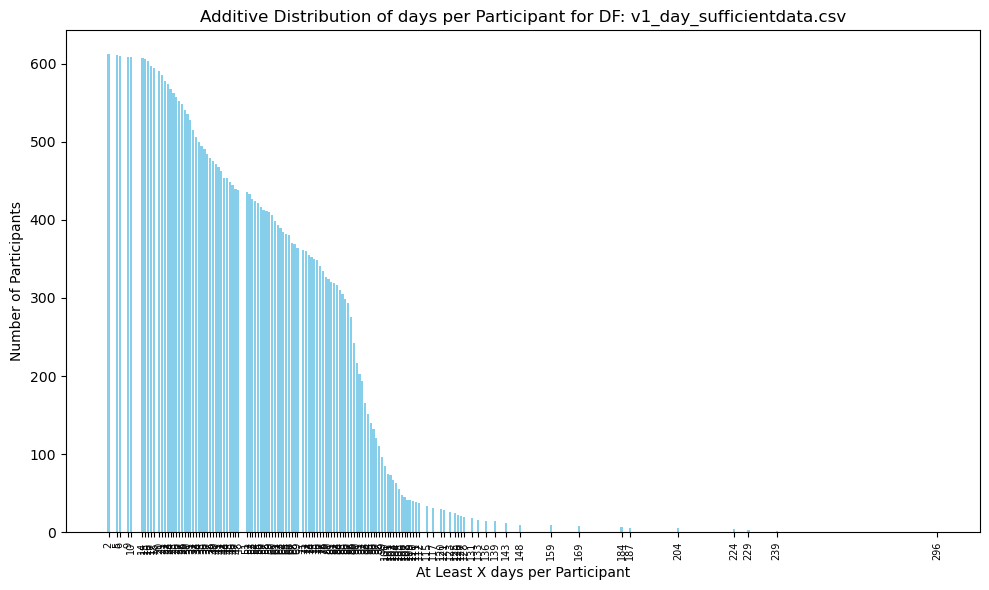

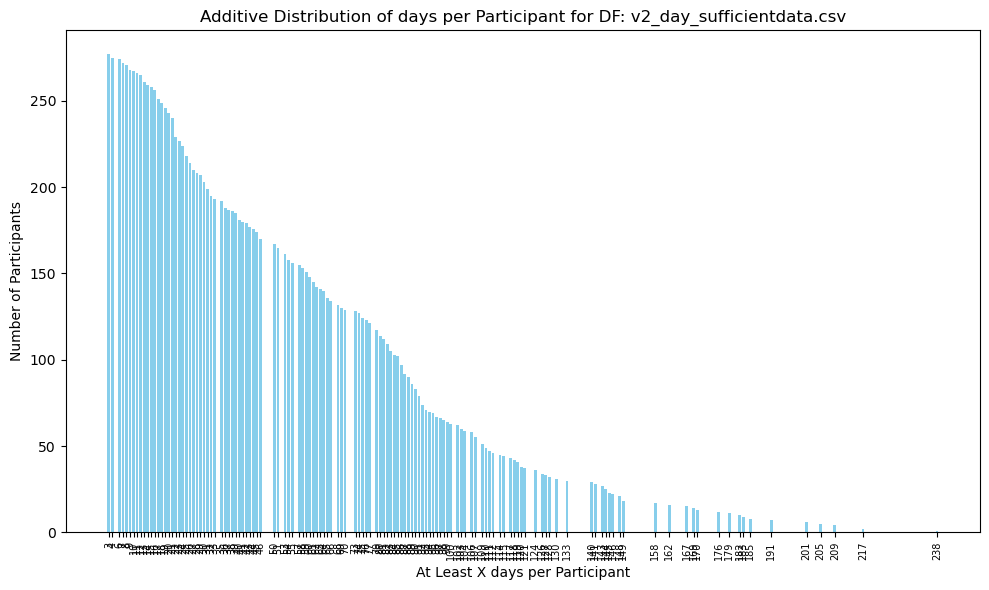

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/378799651.py:3: DtypeWarning: Columns (62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_sufficientdata.csv'))


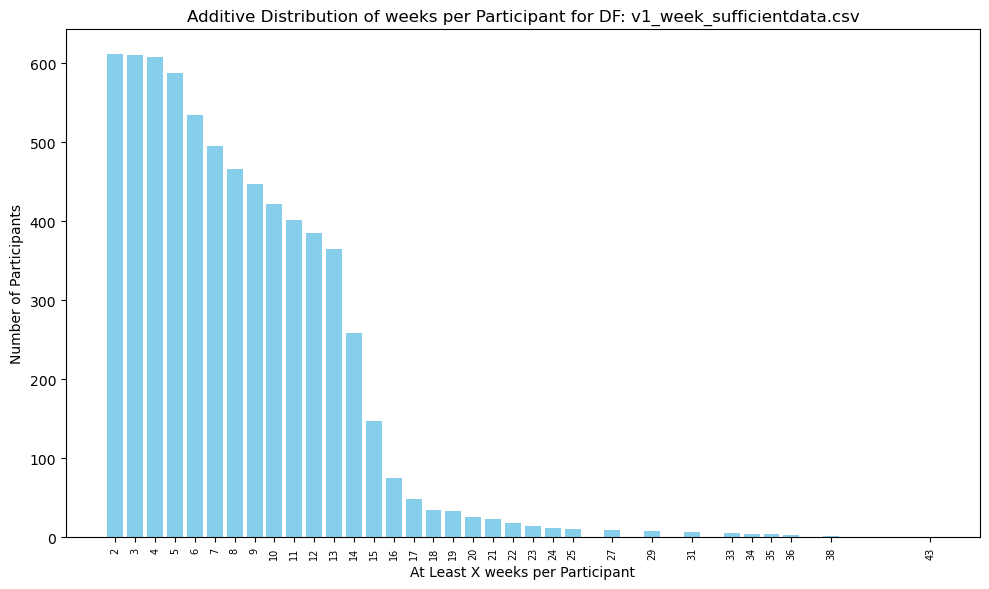

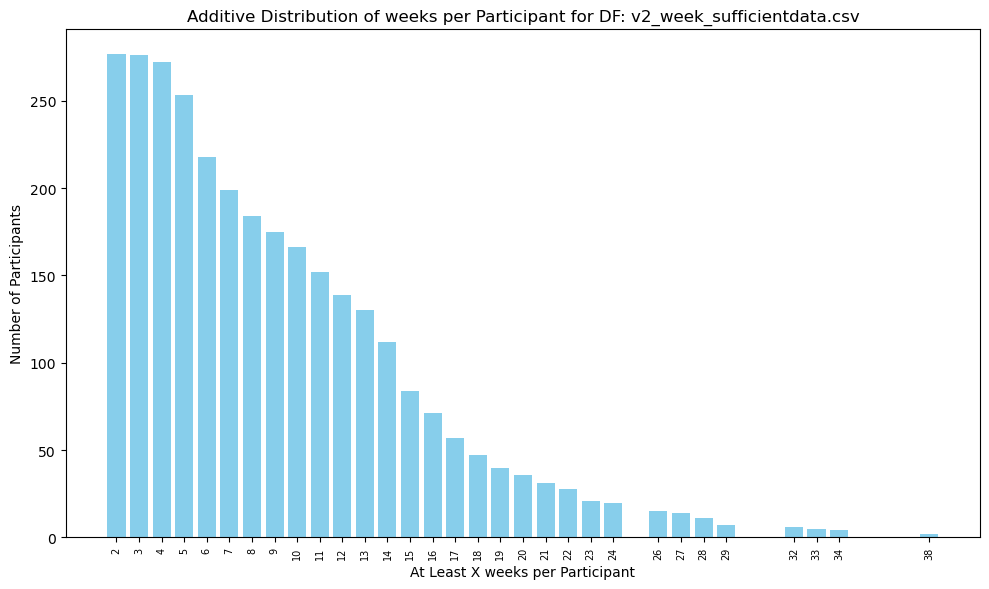

In [ ]:
############## Plot-- how many weeks/days does each participant have #############
for name in df_names:
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_sufficientdata.csv'))
	if 'day' in name:
		time_period='day'
	elif 'week' in name:
		 time_period='week'

	vis.plot_participants_per_time(df, time_period=time_period, title=f'{name}_sufficientdata.csv')


### Some columns we can assume 0 values are actually NaN
For example, hours_of_sleep at at 0 actually probably indicates that the sensor wasn't picking up at that time or it was inaccurate. Same goes for hours_walking or distance_walking, since it doesn't make sense for someone to not move at all during the day. If they have very small amounts of walking/activity, that can stay, but a pure 0 means the sensor wasn't active. 

A mobility radius of >0.0015 means that the two farthest points between which a person moved was less than 200ft during a day,  which is unlikely even if they stayed in a small apartment. 
A mobility score of >0.03 means a person moved less than 200ft during a day, which is again unlikely. 

For the per-hour calculations, they are smaller and harder to generalize to real behavior, but if the score is 0 for mobility sensing, then it's fair to say the sensor wasn't representative of real behavior.



In [ ]:
#We'll change these columns 0s to NaN
na_thresholds = {
	'mobility_radius': 0.0015,
	'mobility': 0.03,
	'distance_active_hr': 0, 
	'hours_stationary_hr': 0.02, #corresponds to least 30 minutes stationary (cumulative) during the day
	'hours_walking_hr': 0.006,  #corresponds to at least 10minutes walking (cumulative) during the day
	'hours_of_sleep_hr': 0.08 #corresponds to at least 2hrs of sleep during the day
	}

below_thresh = {}
for name in ['v1_day','v2_day', 'v1_week', 'v2_week']:
	print(name)
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_sufficientdata.csv'))
	df_setNaN = df.copy()
	for col in na_thresholds:
		if col in df_setNaN.columns:
			df_setNaN.loc[df[col] <= na_thresholds[col], col] = np.nan
			below_thresh = df_setNaN[col].loc[df[col] <= na_thresholds[col]].shape[0]
			post_thresh = df_setNaN[col][df[col] <= na_thresholds[col]].sum()
			print(f'For {col}, replaced values <= {na_thresholds[col]} with NaN. Before: {below_thresh}, after: {post_thresh}')
	display(df_setNaN[id_columns+[col for col in df_setNaN.columns if col not in id_columns]].head())
	df_setNaN.to_csv(os.path.join(brighten_dir, f'{name}_setNaN.csv'), index=False)
	print(f"Created {name}_setNaN.csv in brighten_dir")


v1_day
For mobility_radius, replaced values <= 0.0015 with NaN. Before: 1147, after: 0.0
For mobility, replaced values <= 0.03 with NaN. Before: 2617, after: 0.0


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/1463345583.py:14: DtypeWarning: Columns (61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_sufficientdata.csv'))


,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,working,income_satisfaction,income_lastyear,marital_status,race,age,heard_about_us,device,study_arm,month
0,0.0,2014-07-11,0,0,0.0_0,0.0_0,V1,summer,5,NaN,...,1.0,3.0,6.0,2.0,2.0,14.0,6.0,1.0,2.0,7
1,0.0,2014-08-01,3,21,0.0_3,0.0_21,V1,summer,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
2,0.0,2014-08-02,3,22,0.0_3,0.0_22,V1,summer,6,PST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3,0.0,2014-08-03,3,23,0.0_3,0.0_23,V1,summer,7,PST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
4,0.0,2014-08-04,3,24,0.0_3,0.0_24,V1,summer,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


Created v1_day_setNaN.csv in brighten_dir
v2_day
For distance_active_hr, replaced values <= 0 with NaN. Before: 1730, after: 0.0
For hours_of_sleep_hr, replaced values <= 0.08 with NaN. Before: 4290, after: 0.0


,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,month,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,location_variance_hr
0,213.0,2016-08-12,0,0,213.0_0,213.0_0,V2,summer,5,NaN,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,213.0,2016-08-13,0,1,213.0_0,213.0_1,V2,summer,6,NaN,...,8,50.590909,0.006091,81.690909,10155.036364,0.001545,0.383364,526.772727,0.195455,-0.103364
2,213.0,2016-08-14,0,2,213.0_0,213.0_2,V2,summer,7,NaN,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,213.0,2016-08-15,0,3,213.0_0,213.0_3,V2,summer,1,NaN,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,213.0,2016-08-16,0,4,213.0_0,213.0_4,V2,summer,2,NaN,...,8,263.558333,0.068083,433.225000,120.066667,0.000000,0.429167,0.000000,0.001417,-0.284417


Created v2_day_setNaN.csv in brighten_dir
v1_week
For mobility_radius, replaced values <= 0.0015 with NaN. Before: 1147, after: 0.0
For mobility, replaced values <= 0.03 with NaN. Before: 2617, after: 0.0


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/1463345583.py:14: DtypeWarning: Columns (62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_sufficientdata.csv'))


,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,working,income_satisfaction,income_lastyear,marital_status,race,age,heard_about_us,device,study_arm,month
0,0.0,2014-07-11,0.0,0.0,0.0_0,0.0_0,V1,summer,5.0,NaN,...,1.0,3.0,6.0,2.0,2.0,14.0,6.0,1.0,2.0,7.0
1,0.0,2014-08-01,3.0,21.0,0.0_3,0.0_21,V1,summer,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
2,0.0,2014-08-02,3.0,22.0,0.0_3,0.0_22,V1,summer,6.0,PST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
3,0.0,2014-08-03,3.0,23.0,0.0_3,0.0_23,V1,summer,7.0,PST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
4,0.0,2014-08-04,3.0,24.0,0.0_3,0.0_24,V1,summer,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0


Created v1_week_setNaN.csv in brighten_dir
v2_week
For distance_active_hr, replaced values <= 0 with NaN. Before: 1730, after: 0.0
For hours_of_sleep_hr, replaced values <= 0.08 with NaN. Before: 4290, after: 0.0


,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,month,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,location_variance_hr
0,1001.0,2016-10-21,0.0,0.0,1001.0_0,1001.0_0,V2,fall,5.0,NaN,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001.0,2016-10-31,1.0,10.0,1001.0_1,1001.0_10,V2,fall,1.0,NaN,...,10.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,-0.398375
2,1001.0,2016-11-01,1.0,11.0,1001.0_1,1001.0_11,V2,fall,2.0,NaN,...,11.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,-1.030300
3,1001.0,2016-11-02,1.0,12.0,1001.0_1,1001.0_12,V2,fall,3.0,NaN,...,11.0,0.0,0.0,NaN,0.0,0.0,0.716652,0.0,0.0,-0.459870
4,1001.0,2016-11-03,1.0,13.0,1001.0_1,1001.0_13,V2,fall,4.0,NaN,...,11.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,-0.437708


Created v2_week_setNaN.csv in brighten_dir


In [ ]:
#Binarize + add indicator cols
from scripts.variables import daily_v2_phone

for name in ['v1_day','v2_day', 'v1_week', 'v2_week']:
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_setNaN.csv'))
	binarize_cols = [col for col in df.columns if col in ['hours_high_speed_transportation_hr','distance_high_speed_transportation_hr']+daily_v2_phone]
	indicator_cols = [col for col in df.columns if col in daily_cols_v1+daily_cols_v2]
	for col in binarize_cols:
		df[col] = pd.to_numeric(df[col])
		# Create binarized
		df[f'{col}_bin'] = (df[col] > 0).astype(int)
		df[f'{col}_nonzero'] = np.where(df[col].astype(str).str.contains('0'), np.nan, df[col])

	for col in indicator_cols:
		try:
			df[col] = pd.to_numeric(df[col])
		except Exception as e:
			print(f'Skipping {col}, non-numeric')
			continue
		# Create binary indigator
		df[f'{col}_indicator'] = (df[col] > 0).astype(int)
		print(f"Created indicator col for {col}, {col}_indicator:")
		print(df[f'{col}_indicator'].value_counts())

 
	df[f'phq2_indicator'] = df['phq2_sum'].isnull().astype(int)
	
	print(f"Final cols df: {df.columns.to_list()}")
	df.to_csv(os.path.join(brighten_dir, f'{name}_binarized.csv'))
	display(df[id_columns+[col for col in df.columns if col not in id_columns]].head())
	print(f"Saved {name} to {name}_binarized.csv")
	

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/3581992224.py:5: DtypeWarning: Columns (61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_setNaN.csv'))


Created indicator col for aggregate_communication, aggregate_communication_indicator:
aggregate_communication_indicator
0    25868
1    18922
Name: count, dtype: int64
Created indicator col for call_count, call_count_indicator:
call_count_indicator
0    28864
1    15926
Name: count, dtype: int64
Created indicator col for call_duration, call_duration_indicator:
call_duration_indicator
0    28864
1    15926
Name: count, dtype: int64
Created indicator col for interaction_diversity, interaction_diversity_indicator:
interaction_diversity_indicator
0    25906
1    18884
Name: count, dtype: int64
Created indicator col for missed_interactions, missed_interactions_indicator:
missed_interactions_indicator
0    34602
1    10188
Name: count, dtype: int64
Created indicator col for mobility, mobility_indicator:
mobility_indicator
0    23333
1    21457
Name: count, dtype: int64
Created indicator col for mobility_radius, mobility_radius_indicator:
mobility_radius_indicator
1    22924
0    21866
Name: 

,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,call_count_indicator,call_duration_indicator,interaction_diversity_indicator,missed_interactions_indicator,mobility_indicator,mobility_radius_indicator,sms_count_indicator,sms_length_indicator,unreturned_calls_indicator,phq2_indicator
0,0.0,2014-07-11,0,0,0.0_0,0.0_0,V1,summer,5,NaN,...,0,0,0,0,0,0,0,0,0,1
1,0.0,2014-08-01,3,21,0.0_3,0.0_21,V1,summer,5,NaN,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2014-08-02,3,22,0.0_3,0.0_22,V1,summer,6,PST,...,0,0,0,0,1,1,0,0,0,0
3,0.0,2014-08-03,3,23,0.0_3,0.0_23,V1,summer,7,PST,...,0,0,0,0,1,1,0,0,0,1
4,0.0,2014-08-04,3,24,0.0_3,0.0_24,V1,summer,1,NaN,...,0,0,0,0,0,0,0,0,0,0


Saved v1_day to v1_day_binarized.csv
Created indicator col for callDuration_incoming, callDuration_incoming_indicator:
callDuration_incoming_indicator
0    18453
1      965
Name: count, dtype: int64
Created indicator col for callDuration_outgoing, callDuration_outgoing_indicator:
callDuration_outgoing_indicator
0    18177
1     1241
Name: count, dtype: int64
Created indicator col for callCount_incoming, callCount_incoming_indicator:
callCount_incoming_indicator
0    19418
Name: count, dtype: int64
Created indicator col for callCount_missed, callCount_missed_indicator:
callCount_missed_indicator
0    19418
Name: count, dtype: int64
Created indicator col for callCount_outgoing, callCount_outgoing_indicator:
callCount_outgoing_indicator
0    19418
Name: count, dtype: int64
Created indicator col for textCount, textCount_indicator:
textCount_indicator
0    19385
1       33
Name: count, dtype: int64
Created indicator col for textCount_received, textCount_received_indicator:
textCount_receive

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/3581992224.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_indicator'] = (df[col] > 0).astype(int)
/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/3581992224.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_indicator'] = (df[col] > 0).astype(int)
/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/3581992224.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,distance_active_indicator,distance_high_speed_transportation_indicator,distance_powered_vehicle_indicator,distance_walking_indicator,hours_active_indicator,hours_high_speed_transportation_indicator,hours_of_sleep_indicator,hours_powered_vehicle_indicator,location_variance_indicator,phq2_indicator
0,213.0,2016-08-12,0,0,213.0_0,213.0_0,V2,summer,5,NaN,...,0,0,0,0,0,0,0,0,0,1
1,213.0,2016-08-13,0,1,213.0_0,213.0_1,V2,summer,6,NaN,...,1,1,1,1,1,1,1,1,0,1
2,213.0,2016-08-14,0,2,213.0_0,213.0_2,V2,summer,7,NaN,...,0,0,0,0,0,0,1,0,0,1
3,213.0,2016-08-15,0,3,213.0_0,213.0_3,V2,summer,1,NaN,...,0,0,0,0,0,0,1,0,0,1
4,213.0,2016-08-16,0,4,213.0_0,213.0_4,V2,summer,2,NaN,...,1,0,1,1,1,0,1,1,0,1


Saved v2_day to v2_day_binarized.csv
Created indicator col for aggregate_communication, aggregate_communication_indicator:
aggregate_communication_indicator
0    25868
1    18922
Name: count, dtype: int64
Created indicator col for call_count, call_count_indicator:
call_count_indicator
0    28864
1    15926
Name: count, dtype: int64
Created indicator col for call_duration, call_duration_indicator:
call_duration_indicator
0    28864
1    15926
Name: count, dtype: int64
Created indicator col for interaction_diversity, interaction_diversity_indicator:
interaction_diversity_indicator
0    25906
1    18884
Name: count, dtype: int64
Created indicator col for missed_interactions, missed_interactions_indicator:
missed_interactions_indicator
0    34602
1    10188
Name: count, dtype: int64
Created indicator col for mobility, mobility_indicator:
mobility_indicator
0    23333
1    21457
Name: count, dtype: int64
Created indicator col for mobility_radius, mobility_radius_indicator:
mobility_radius_i

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/3581992224.py:5: DtypeWarning: Columns (62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_setNaN.csv'))


,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,call_count_indicator,call_duration_indicator,interaction_diversity_indicator,missed_interactions_indicator,mobility_indicator,mobility_radius_indicator,sms_count_indicator,sms_length_indicator,unreturned_calls_indicator,phq2_indicator
0,0.0,2014-07-11,0.0,0.0,0.0_0,0.0_0,V1,summer,5.0,NaN,...,0,0,0,0,0,0,0,0,0,1
1,0.0,2014-08-01,3.0,21.0,0.0_3,0.0_21,V1,summer,5.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2014-08-02,3.0,22.0,0.0_3,0.0_22,V1,summer,6.0,PST,...,0,0,0,0,1,1,0,0,0,0
3,0.0,2014-08-03,3.0,23.0,0.0_3,0.0_23,V1,summer,7.0,PST,...,0,0,0,0,1,1,0,0,0,1
4,0.0,2014-08-04,3.0,24.0,0.0_3,0.0_24,V1,summer,1.0,NaN,...,0,0,0,0,0,0,0,0,0,0


Saved v1_week to v1_week_binarized.csv
Created indicator col for callDuration_incoming, callDuration_incoming_indicator:
callDuration_incoming_indicator
0    18453
1      965
Name: count, dtype: int64
Created indicator col for callDuration_outgoing, callDuration_outgoing_indicator:
callDuration_outgoing_indicator
0    18177
1     1241
Name: count, dtype: int64
Created indicator col for callCount_incoming, callCount_incoming_indicator:
callCount_incoming_indicator
0    19418
Name: count, dtype: int64
Created indicator col for callCount_missed, callCount_missed_indicator:
callCount_missed_indicator
0    19418
Name: count, dtype: int64
Created indicator col for callCount_outgoing, callCount_outgoing_indicator:
callCount_outgoing_indicator
0    19418
Name: count, dtype: int64
Created indicator col for textCount, textCount_indicator:
textCount_indicator
0    19385
1       33
Name: count, dtype: int64
Created indicator col for textCount_received, textCount_received_indicator:
textCount_recei

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/3581992224.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_indicator'] = (df[col] > 0).astype(int)
/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/3581992224.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_indicator'] = (df[col] > 0).astype(int)
/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/3581992224.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

,num_id,dt,week,day,week_id,idx,v,season,day_of_week,cohort,...,distance_active_indicator,distance_high_speed_transportation_indicator,distance_powered_vehicle_indicator,distance_walking_indicator,hours_active_indicator,hours_high_speed_transportation_indicator,hours_of_sleep_indicator,hours_powered_vehicle_indicator,location_variance_indicator,phq2_indicator
0,1001.0,2016-10-21,0.0,0.0,1001.0_0,1001.0_0,V2,fall,5.0,NaN,...,0,0,0,0,0,0,0,0,0,1
1,1001.0,2016-10-31,1.0,10.0,1001.0_1,1001.0_10,V2,fall,1.0,NaN,...,0,0,0,0,0,0,1,0,0,0
2,1001.0,2016-11-01,1.0,11.0,1001.0_1,1001.0_11,V2,fall,2.0,NaN,...,0,0,0,0,0,0,1,0,0,0
3,1001.0,2016-11-02,1.0,12.0,1001.0_1,1001.0_12,V2,fall,3.0,NaN,...,0,0,0,0,0,0,1,0,0,1
4,1001.0,2016-11-03,1.0,13.0,1001.0_1,1001.0_13,V2,fall,4.0,NaN,...,0,0,0,0,0,0,1,0,0,1


Saved v2_week to v2_week_binarized.csv


## Testing different combinations of rows for # subjects with sufficient data

# This is too computationally costly
 maybe try with categories and having one col from each category
 for now just using filtering


In [ ]:

import itertools
import plotly.express as px 
def optimize_people_vs_columns(df, group_col, feature_cols, coverage_threshold=0.7):
	results = []
	
	for k in range(len(feature_cols), 3, -1):

		for col_subset in itertools.combinations(feature_cols, k):
			#print(col_subset)
			# For each group (person), what % of the selected columns are non-missing?
			group_coverage = (
				df.groupby(group_col)[list(col_subset)]
				.apply(lambda x: x.notna().mean(axis=1).mean())  # overall coverage per person
			)
			keep_ids = group_coverage[group_coverage >= coverage_threshold].index
			filtered_df = df[df[group_col].isin(keep_ids)]
			results.append({
				'num_columns': k,
				'columns': [col_subset],
				'num_people': len(keep_ids),
				'df': filtered_df
			})

	# Choose best tradeoff (e.g., most people, or most data points)
	best = max(results, key=lambda x: x['num_people'] * x['num_columns'])
	print(f'For {name}, best = num_columns {best['num_columns']}, num_people {best['num_people']}, columns = {best['columns']}')

	return best, results


all_results = {}
for name in ['v1_day','v2_day', 'v1_week', 'v2_week']:
	data_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_binarized.csv'))
	best, results = optimize_people_vs_columns(
		data_df,
		group_col='num_id',
		feature_cols=[col for col in daily_cols_v1+daily_cols_v2 if col in data_df.columns.tolist()],
		coverage_threshold=0.7
	)

	all_results[name] = results



/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_4541/2942708893.py:33: DtypeWarning:

Columns (62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.



For v1_day, best = num_columns 10, num_people 270, columns = [('aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'mobility', 'mobility_radius', 'sms_count', 'sms_length', 'unreturned_calls')]


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_4541/2942708893.py:33: DtypeWarning:

Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.



: 

In [217]:
result_df = pd.DataFrame(all)
display(result_df)
fig = px.bar(result_df, x='num_columns', y='num_people', barmode='group')
fig.show()

ValueError: DataFrame constructor not properly called!

In [ ]:
# For now we'll just keep based on coverage threshold
coverage_threshold=0.7

results=[]
for v in ['v1', 'v2']:
	for time in ['day', 'week']:
		print(f"\n=== Processing: {v} {time} ===")
		fname = f'{v}_{time}_binarized.csv'
		df = pd.read_csv(os.path.join(brighten_dir, fname))
		df = df.loc[:, ~df.columns.str.contains(r"^Unnamed")]
		df_filtered_byDay = df.loc[df['day']<85]
		print(f'Subs in df_filtered_byDay: {df_filtered_byDay['num_id'].nunique()}')

		sensor_columns = daily_cols_v1 if v == 'v1' else daily_v2_sensor + daily_v2_weather

		grouped = df_filtered_byDay.groupby('num_id')[sensor_columns].apply(lambda x: x.notna().mean(axis=1).mean())
		keep_ids = grouped[grouped >= coverage_threshold].index
		filtered_df = df_filtered_byDay[df_filtered_byDay['num_id'].isin(keep_ids)]
		filtered_df = filtered_df.drop(columns=[col for col in filtered_df.columns if col in daily_v2_phone])
		print(f'Subs in df_filtered_byCoverage: {filtered_df['num_id'].nunique()}')
		filtered_df.to_csv(os.path.join(brighten_dir, f'{v}_{time}_filtered.csv'))
		print(f'Saved df to {v}_{time}_filtered.csv')




=== Processing: v1 day ===
Subs in df_filtered_byDay: 612


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/3569530240.py:9: DtypeWarning: Columns (62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, fname))


Subs in df_filtered_byCoverage: 260
Saved df to v1_day_filtered.csv

=== Processing: v1 week ===
Subs in df_filtered_byDay: 612


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52403/3569530240.py:9: DtypeWarning: Columns (63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, fname))


Subs in df_filtered_byCoverage: 260
Saved df to v1_week_filtered.csv

=== Processing: v2 day ===
Subs in df_filtered_byDay: 277
Subs in df_filtered_byCoverage: 219
Saved df to v2_day_filtered.csv

=== Processing: v2 week ===
Subs in df_filtered_byDay: 277
Subs in df_filtered_byCoverage: 219
Saved df to v2_week_filtered.csv


# Train test val split

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

for name in ['v1_day','v2_day', 'v1_week', 'v2_week']:
	data_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_filtered.csv'))
	gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
	groups = data_df['num_id'] # groups variable is based on num_id, so that no subjects are in train and test etc, 
	trainval_idx, test_idx = next(gss.split(data_df, groups=groups))
	
	# Get train/test sets
	trainval, test = data_df.iloc[trainval_idx], data_df.iloc[test_idx]

	trainval.to_csv(os.path.join(brighten_dir, f'{name}_trainval.csv'))
	print(trainval.columns.to_list())
	test.to_csv(os.path.join(brighten_dir, f'{name}_test.csv'))


['Unnamed: 0', 'dt', 'participant_id', 'phq9_sum', 'phq9_1', 'phq9_2', 'phq9_3', 'phq9_4', 'phq9_5', 'phq9_6', 'phq9_7', 'phq9_8', 'phq9_9', 'v', 'day', 'phq2_1', 'phq2_2', 'phq2_sum', 'alc_1', 'alc_2', 'alc_3', 'alc_sum', 'gad7_1', 'gad7_2', 'gad7_3', 'gad7_4', 'gad7_5', 'gad7_6', 'gad7_7', 'gad7_8', 'gad7_sum', 'sds_1', 'sds_2', 'sds_3', 'stress', 'support', 'sleep_1', 'sleep_2', 'sleep_3', 'mood_1', 'mhs_1', 'mhs_2', 'mhs_3', 'mhs_4', 'mhs_5', 'cohort', 'user_phone_type', 'aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'mobility', 'mobility_radius', 'sms_count', 'sms_length', 'unreturned_calls', 'hours_accounted_for', 'hours_stationary', 'hours_stationary_nhw', 'hours_walking', 'cid', 'category', 'subcategories', 'phq9_1_base', 'phq9_2_base', 'phq9_3_base', 'phq9_4_base', 'phq9_5_base', 'phq9_6_base', 'phq9_7_base', 'phq9_8_base', 'phq9_9_base', 'study', 'screen_1', 'screen_2', 'screen_3', 'screen_4', 'gender', 'education', '